# Gaussian Copula

The **Gaussian Copula** is a statistical model used to generate synthetic data by capturing the dependencies among variables while allowing each feature to maintain its own marginal distribution. It works by transforming the original data into a multivariate normal space, modeling the correlations between features using a Gaussian distribution, and then mapping the data back to the original feature scales. This approach preserves both linear and certain nonlinear relationships between variables, making it particularly effective for tabular datasets like the Breast Cancer Wisconsin dataset. By leveraging the Gaussian Copula, synthetic data can closely approximate the joint distribution of real data while maintaining flexibility, interpretability, and privacy protection.


In [1]:
'''Importing data and removing unnecessary columns'''


import pandas as pd, numpy as np, warnings
warnings.filterwarnings('ignore')
cancer_data = pd.read_csv('data.csv')

cancer_data.drop(['id', 'Unnamed: 32'], axis=1, inplace = True)
cancer_data.replace({'diagnosis':{'M':1, 'B':0}}, inplace=True)

##### Here I am evaluting different Fidility metrics

Global Fidelity: KS, JS, Wasserstein

In [2]:
# import sdv (synthetic data valut) and generating meta data

import sdv
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cancer_data)

In [3]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality


gaussiancopula = GaussianCopulaSynthesizer(metadata)
gaussiancopula.fit(cancer_data)
synthetic_data_gaussiancopula = gaussiancopula.sample(num_rows=1000)
diagnostic_report = run_diagnostic(cancer_data, synthetic_data_gaussiancopula, metadata)
quality_report = evaluate_quality(cancer_data, synthetic_data_gaussiancopula, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 4076.22it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 281.74it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 927.16it/s]|
Column Shapes Score: 93.0%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 357.79it/s]|
Column Pair Trends Score: 95.75%

Overall Score (Average): 94.37%



## Kolmogrov-simrov (KS) test (Max CDF difference between real/synthetic)

In [4]:
from sdv.evaluation.single_table import QualityReport

# 1. Initialize report
quality_report = QualityReport()

# 2. Generate with metadata converted to dict
quality_report.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_gaussiancopula,
    metadata=metadata.to_dict()  
)

# 3. Get details
details = quality_report.get_details('Column Shapes')
print(details)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 944.83it/s]|
Column Shapes Score: 93.0%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 381.58it/s]|
Column Pair Trends Score: 95.75%

Overall Score (Average): 94.37%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.981417
1               radius_mean  KSComplement  0.947687
2              texture_mean  KSComplement  0.961807
3            perimeter_mean  KSComplement  0.942840
4                 area_mean  KSComplement  0.944355
5           smoothness_mean  KSComplement  0.962114
6          compactness_mean  KSComplement  0.964169
7            concavity_mean  KSComplement  0.952998
8       concave points_mean  KSComplement  0.893146
9             symmetry_mean  KSComplement  0.971624
10   fractal_dimension_mean  KSComplement  0.928684
11                radius_se  KSComplement  0.945401
12               texture_se  KSComplement  

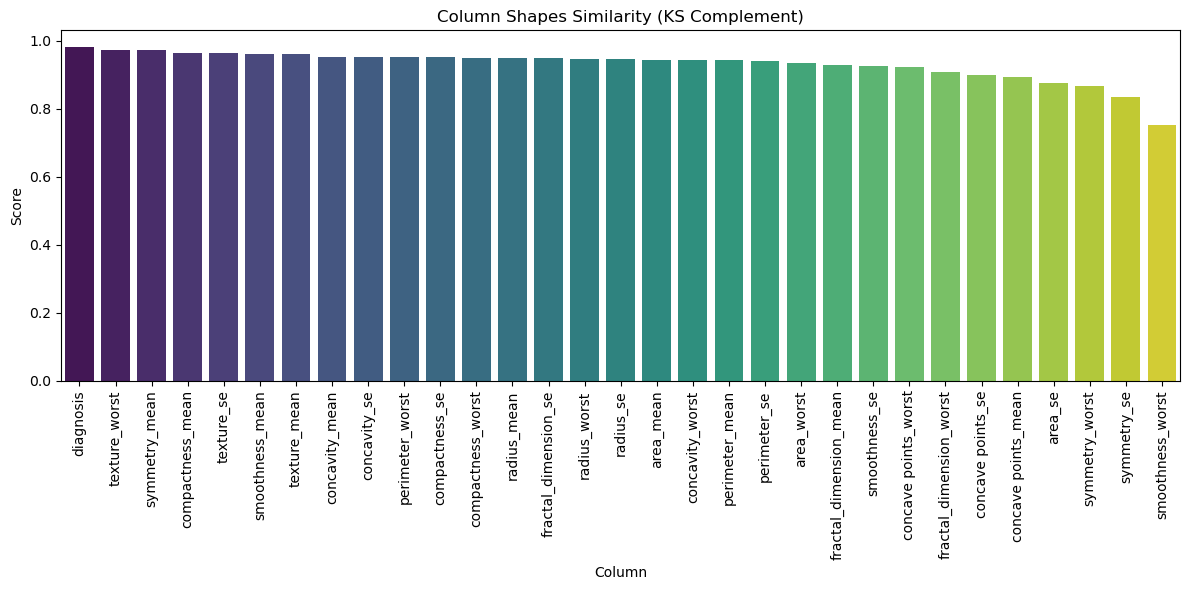

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Jensenshannon Distance (Distribution similarity measure)

In [6]:
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import MinMaxScaler

def _prob_vectors_numeric(real, synth, bins=30, eps=1e-12):
    """Convert numeric columns into comparable probability vectors."""
    real = pd.to_numeric(real, errors='coerce').dropna().to_numpy()
    synth = pd.to_numeric(synth, errors='coerce').dropna().to_numpy()

    edges = np.histogram_bin_edges(np.concatenate([real, synth]), bins=bins)
    r_hist, _ = np.histogram(real, bins=edges)
    s_hist, _ = np.histogram(synth, bins=edges)

    r = r_hist.astype(float) + eps
    s = s_hist.astype(float) + eps
    r /= r.sum()
    s /= s.sum()
    return r, s

def _prob_vectors_categorical(real, synth, eps=1e-12):
    """Convert categorical columns into comparable probability vectors."""
    r_counts = real.astype(str).value_counts(dropna=False)
    s_counts = synth.astype(str).value_counts(dropna=False)
    keys = r_counts.index.union(s_counts.index)
    r = r_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    s = s_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    r /= r.sum()
    s /= s.sum()
    return r, s, keys

# ---------- Main function ----------

def compute_js_divergence(real_df: pd.DataFrame,
                          synth_df: pd.DataFrame,
                          bins=30,
                          normalize=True) -> pd.DataFrame:
    """
    Compute Jensen–Shannon Divergence for each column between real and synthetic data.
    Returns a DataFrame with per-feature JS divergence values.
    """

    common_cols = [c for c in real_df.columns if c in synth_df.columns]
    real = real_df[common_cols].copy()
    synth = synth_df[common_cols].copy()

    # Optional normalization for numeric columns
    if normalize:
        num_cols = [c for c in common_cols if is_numeric_dtype(real[c])]
        scaler = MinMaxScaler()
        real[num_cols] = scaler.fit_transform(real[num_cols])
        synth[num_cols] = scaler.transform(synth[num_cols])

    results = []
    for col in common_cols:
        r_col, s_col = real[col], synth[col]

        if is_numeric_dtype(r_col):
            p, q = _prob_vectors_numeric(r_col, s_col, bins=bins)
        else:
            p, q, _ = _prob_vectors_categorical(r_col, s_col)

        # Jensen-Shannon divergence (base=2 → bounded [0,1])
        js_div = jensenshannon(p, q, base=2) ** 2

        results.append({"Feature": col, "JS_Divergence": js_div})

    return pd.DataFrame(results).sort_values("JS_Divergence")   

results = compute_js_divergence(cancer_data, synthetic_data_gaussiancopula, bins="fd", normalize=True)
print(results) 

                    Feature  JS_Divergence
0                 diagnosis       0.000269
22            texture_worst       0.010297
7            concavity_mean       0.013621
26        compactness_worst       0.014229
2              texture_mean       0.014899
10   fractal_dimension_mean       0.015039
12               texture_se       0.016604
6          compactness_mean       0.016822
3            perimeter_mean       0.016845
23          perimeter_worst       0.017322
9             symmetry_mean       0.018458
1               radius_mean       0.018693
21             radius_worst       0.018777
28     concave points_worst       0.019439
17             concavity_se       0.019649
20     fractal_dimension_se       0.020011
11                radius_se       0.020134
16           compactness_se       0.021314
5           smoothness_mean       0.021459
13             perimeter_se       0.022563
27          concavity_worst       0.023242
15            smoothness_se       0.024393
4          

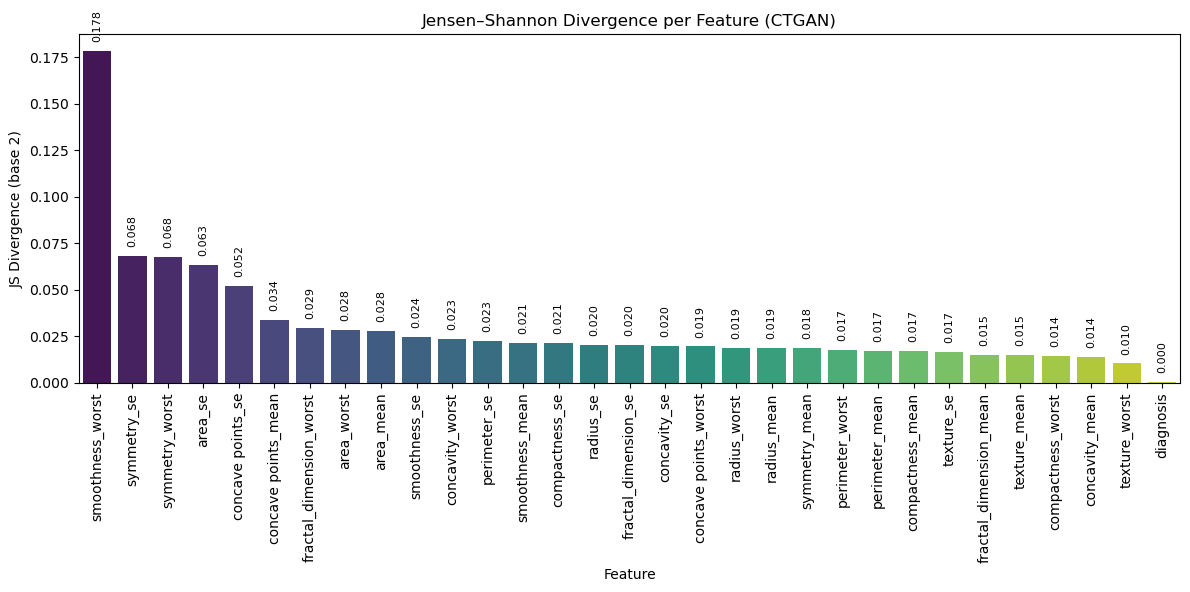

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute JS divergence
results = compute_js_divergence(cancer_data, synthetic_data_gaussiancopula, bins="fd", normalize=True)

# Sort for better readability
results = results.sort_values("JS_Divergence", ascending=False)

# Create bar chart
plt.figure(figsize=(12,6))
bars = sns.barplot(x="Feature", y="JS_Divergence", data=results, palette="viridis")

# Add value labels on each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,                    # vertical offset
        f"{yval:.3f}",                   # formatted value
        ha="center", va="bottom", fontsize=8, rotation=90
    )

# Aesthetics
plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Jensen–Shannon Divergence per Feature (CTGAN)")
plt.tight_layout()
plt.show()

## Wasserstein Distance (Distance between full distributions)

In [8]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance
import pandas as pd

# Assume cancer_data (real) and synthetic_data (synthetic) are your DataFrames

# Initialize MinMax scaler
scaler = MinMaxScaler()


# Fit on the real data and transform both
real_scaled = pd.DataFrame(scaler.fit_transform(cancer_data), columns=cancer_data.columns)
synthetic_scaled = pd.DataFrame(scaler.transform(synthetic_data_gaussiancopula), columns=synthetic_data_gaussiancopula.columns)

# Compute normalized Wasserstein distance
for col in cancer_data.columns:
    dist = wasserstein_distance(real_scaled[col], synthetic_scaled[col])
    print(f"{col}: {dist:.4f}")

diagnosis: 0.0186
radius_mean: 0.0115
texture_mean: 0.0065
perimeter_mean: 0.0111
area_mean: 0.0126
smoothness_mean: 0.0071
compactness_mean: 0.0074
concavity_mean: 0.0114
concave points_mean: 0.0165
symmetry_mean: 0.0075
fractal_dimension_mean: 0.0161
radius_se: 0.0085
texture_se: 0.0062
perimeter_se: 0.0082
area_se: 0.0119
smoothness_se: 0.0137
compactness_se: 0.0096
concavity_se: 0.0073
concave points_se: 0.0225
symmetry_se: 0.0280
fractal_dimension_se: 0.0095
radius_worst: 0.0136
texture_worst: 0.0041
perimeter_worst: 0.0126
area_worst: 0.0135
smoothness_worst: 0.0660
compactness_worst: 0.0100
concavity_worst: 0.0178
concave points_worst: 0.0194
symmetry_worst: 0.0326
fractal_dimension_worst: 0.0176


In [9]:
import gower 

# remove the target variable for gower distance calculation

X_real = cancer_data.drop('diagnosis', axis=1)
X_synth = synthetic_data_gaussiancopula.drop('diagnosis', axis=1) 

# compute gower distance

gower_real = 1 - gower.gower_matrix(X_real)
gower_synth = 1 - gower.gower_matrix(X_synth)
gower_combined = 1 - gower.gower_matrix(pd.concat([X_real, X_synth], axis=0))

# upper triangle indices

real_upper = gower_real[np.triu_indices_from(gower_real, k=1)]
synth_upper = gower_synth[np.triu_indices_from(gower_synth, k=1)]

# Max and average intra-set similarity

max_intra_real = np.max(real_upper)
avg_intra_real = np.mean(real_upper)

max_intra_synth = np.max(synth_upper)
avg_intra_synth = np.mean(synth_upper)

# Flatten the cross-set matrix
cross_flat = gower_combined.flatten()

max_cross = np.max(cross_flat)
avg_cross = np.mean(cross_flat)
print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real:.4f}, Avg = {avg_intra_real:.4f}\n")

print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth:.4f}, Avg = {avg_intra_synth:.4f}\n")

print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross:.4f}, Avg = {avg_cross:.4f}")

Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9787, Avg = 0.8238

Cross-set Similarity (Real vs Synthetic):
Max = 1.0000, Avg = 0.8522


### t-SNE = Local Fidelity / Distribution Visualization Metric

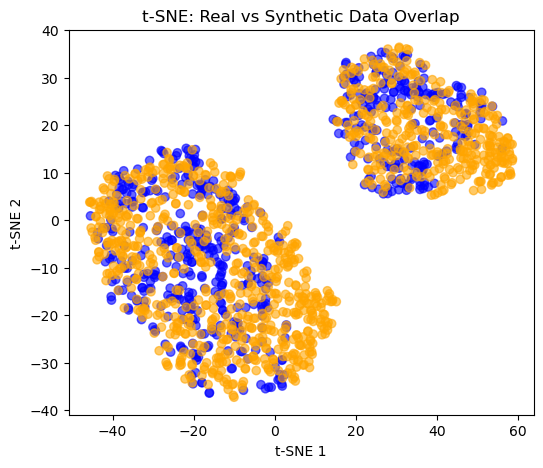

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined = np.vstack([real_scaled, synthetic_scaled])
tsne_result = tsne.fit_transform(combined)
labels = ['Real'] * len(real_scaled) + ['Synthetic'] * len(synthetic_scaled)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels],
            alpha=0.6, label=None)
plt.title("t-SNE: Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# Distributional similarity metrics

MMD — Maximum Mean Discrepancy (statistical distance that measures the difference between the distributions of two datasets)

In [11]:
from sklearn.preprocessing import StandardScaler    
from scipy.stats import wasserstein_distance

scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_gaussiancopula.drop(columns=['diagnosis']))

# MMD (using Gaussian kernel)
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score = compute_mmd(real_scaled, synthetic_scaled)


print(f"MMD score: {mmd_score:.4f}")

MMD score: 0.0039


### Cosine Similarity Metrics

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity
cross_sim = cosine_similarity(real_scaled, synthetic_scaled)
avg_sim = np.mean(cross_sim)
max_sim = np.max(cross_sim)


print(f"\n ----- Sample-Level Similarity--------- \n")

print(f"Average cosine similarity: {avg_sim:.4f}")
print(f"Maximum cosine similarity: {max_sim:.4f}")


 ----- Sample-Level Similarity--------- 

Average cosine similarity: 0.0128
Maximum cosine similarity: 0.9734


# Utility 

In [14]:
# TSTR (Train on synthetic and test on real data)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define real and synthetic datasets
real_data = cancer_data
synthetic_data = synthetic_data_gaussiancopula

# -----------------------------
# 1. Train on Synthetic → Test on Real (TSTR)
# -----------------------------

# Split synthetic data (train/test)
X_synth = synthetic_data.drop(['diagnosis'], axis=1)
y_synth = synthetic_data['diagnosis']
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Split real data (train/test)
X_real = real_data.drop(['diagnosis'], axis=1)
y_real = real_data['diagnosis']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Scale features using scaler fitted on synthetic training data
scaler = StandardScaler().fit(X_train_synth)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_real_scaled = scaler.transform(X_test_real)

# Train model on synthetic data
model_tstr = RandomForestClassifier(random_state=42)
model_tstr.fit(X_train_synth_scaled, y_train_synth)

# Test on real data
y_pred_real = model_tstr.predict(X_test_real_scaled)
y_pred_prob_real = model_tstr.predict_proba(X_test_real_scaled)[:, 1]

# Evaluate TSTR performance
acc_tstr = accuracy_score(y_test_real, y_pred_real)
f1_tstr = f1_score(y_test_real, y_pred_real)
auc_tstr = roc_auc_score(y_test_real, y_pred_prob_real)

print("Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc_tstr:.3f}")
print(f"F1 Score = {f1_tstr:.3f}")
print(f"AUC = {auc_tstr:.3f}")


# -----------------------------
# 2. Baseline: Train Real → Test Real (TRTR)
# -----------------------------

# Scale real data using scaler fitted on real training set
scaler_real = StandardScaler().fit(X_train_real)
X_train_real_scaled = scaler_real.transform(X_train_real)
X_test_real_scaled_baseline = scaler_real.transform(X_test_real)

# Train on real data
model_baseline = RandomForestClassifier(random_state=42)
model_baseline.fit(X_train_real_scaled, y_train_real)

# Test on real data
y_pred_baseline = model_baseline.predict(X_test_real_scaled_baseline)
y_pred_prob_baseline = model_baseline.predict_proba(X_test_real_scaled_baseline)[:, 1]

# Evaluate baseline model
acc_trtr = accuracy_score(y_test_real, y_pred_baseline)
f1_trtr = f1_score(y_test_real, y_pred_baseline)
auc_trtr = roc_auc_score(y_test_real, y_pred_prob_baseline)

print("\nBaseline: Train on Real, Test on Real (TRTR):")
print(f"Accuracy = {acc_trtr:.3f}")
print(f"F1 Score = {f1_trtr:.3f}")
print(f"AUC = {auc_trtr:.3f}")

Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.930
F1 Score = 0.897
AUC = 0.988

Baseline: Train on Real, Test on Real (TRTR):
Accuracy = 0.965
F1 Score = 0.952
AUC = 0.995


# Privacy

In [15]:
# Privacy (Nearest Neighbor Distance)

from sklearn.neighbors import NearestNeighbors

# Standardize using the same scaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_gaussiancopula.drop(columns=['diagnosis']))

# Compute Nearest Neighbor Distance
nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
distances, _ = nn.kneighbors(synthetic_scaled)
avg_nn_dist = np.mean(distances)

print("Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist:.4f}")

Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 2.7229


# Bivariate analysis 

In [19]:
from itertools import combinations
import numpy as np, pandas as pd
from scipy import stats

real_df = cancer_data
synth_df = synthetic_data_gaussiancopula

# Make sure column names match
synth_df = synth_df[real_df.columns]

num_cols = [c for c in real_df.columns if c != "diagnosis"]
cat_cols = ["diagnosis"]

In [20]:
def bivariate_quality_cancer(real_df, synth_df, target = 'diagnosis'):
    num_cols 
    results_corr = []
    results_target = []

    # numeric to numeric 

    for a, b in combinations(num_cols, 2):
        r_corr = real_df[[a,b]].corr().iloc[0,1]
        s_corr = synth_df[[a,b]].corr().iloc[0,1]
        results_corr.append({'var_a':a, 'var_b':b, 'delta_corr': abs(r_corr-s_corr)})
    
    # numeric to target 

    for col in num_cols:
        r_groups = [g[col].values for _, g in real_df.groupby(target)]
        s_groups = [g[col].values for _, g in synth_df.groupby(target)]
        if len(r_groups) == 2:
            d_real = stats.wasserstein_distance(*r_groups)
            d_synth = stats.wasserstein_distance(*s_groups)
            results_target.append({"feature": col, "delta_wasserstein": abs(d_real - d_synth)})

    return(pd.DataFrame(results_corr).sort_values("delta_corr", ascending=False),
           pd.DataFrame(results_target).sort_values("delta_wasserstein", ascending=False))

In [21]:
corr_results, target_results = bivariate_quality_cancer(real_df=cancer_data, synth_df=synthetic_data_gaussiancopula)


# Largest differences in pairwise correlations
print(corr_results.head(10))

# Features that differ most by diagnosis class

print('================================')

print(target_results.head(10))

                   var_a                 var_b  delta_corr
190  concave points_mean          concavity_se    0.232499
354         concavity_se  concave points_worst    0.227887
357    concave points_se           symmetry_se    0.227422
365    concave points_se       concavity_worst    0.221213
184  concave points_mean             radius_se    0.218750
170       concavity_mean           symmetry_se    0.217769
162       concavity_mean             radius_se    0.209228
352         concavity_se     compactness_worst    0.205069
191  concave points_mean     concave points_se    0.204101
345         concavity_se           symmetry_se    0.183836
            feature  delta_wasserstein
23       area_worst         393.052094
3         area_mean         226.914463
13          area_se          24.116408
22  perimeter_worst          23.711280
2    perimeter_mean          15.375631
20     radius_worst           3.447554
0       radius_mean           2.183697
21    texture_worst           1.896818


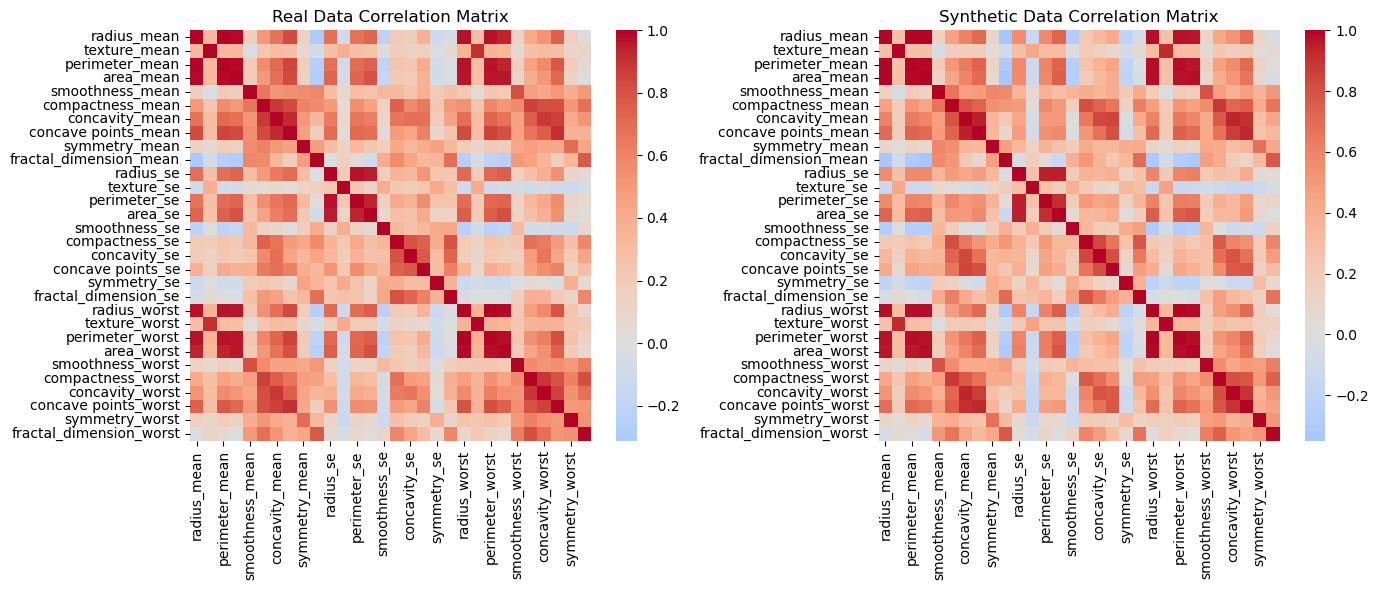

In [22]:
# Compare correlations side by side

# Plotting both correlation metrics as heatmaps 

import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [c for c in real_df.columns if c != "diagnosis"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(real_df[num_cols].corr(), cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Real Data Correlation Matrix")

sns.heatmap(synth_df[num_cols].corr(), cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Synthetic Data Correlation Matrix")

plt.tight_layout()
plt.show()

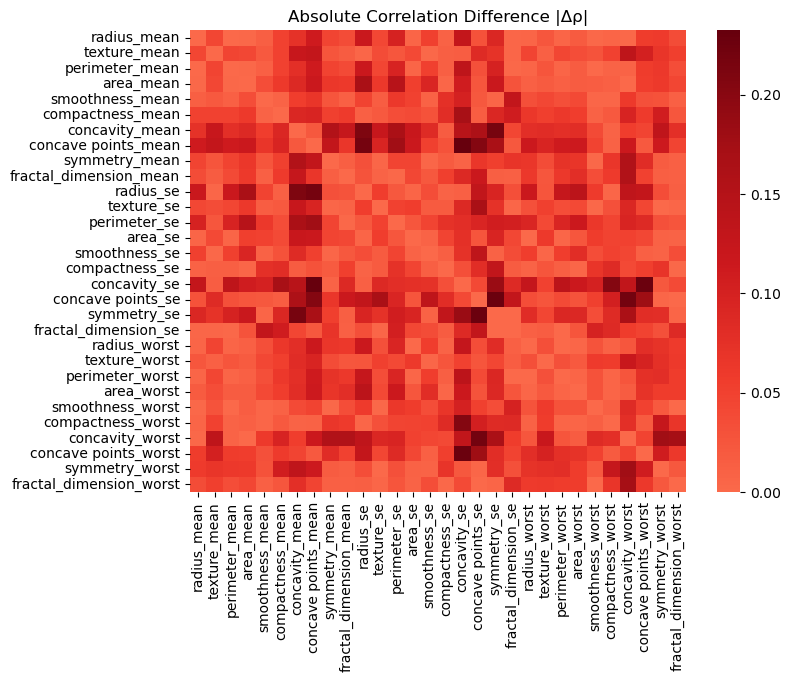

In [23]:
diff_corr = abs(real_df[num_cols].corr() - synth_df[num_cols].corr())
plt.figure(figsize=(8,6))
sns.heatmap(diff_corr, cmap="Reds", center=0)
plt.title("Absolute Correlation Difference |Δρ|")
plt.show()

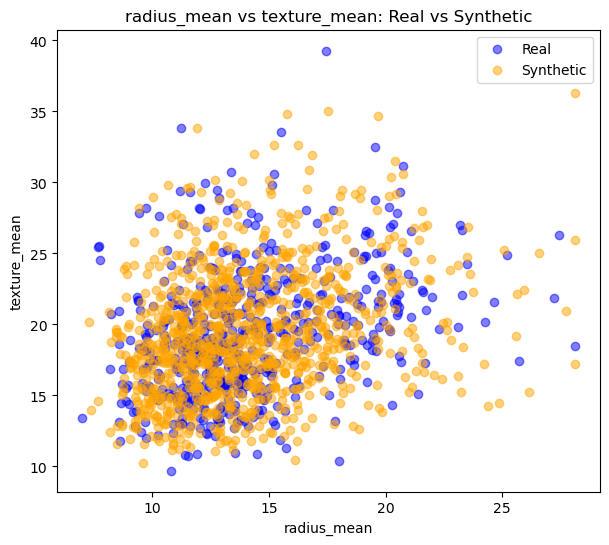

In [24]:
# Overlay 2D scatter (bivariate plot) for selected pair

x = "radius_mean"
y = "texture_mean"

plt.figure(figsize=(7,6))
plt.scatter(real_df[x], real_df[y], alpha=0.5, label="Real", color="blue")
plt.scatter(synth_df[x], synth_df[y], alpha=0.5, label="Synthetic", color="orange")
plt.xlabel(x)
plt.ylabel(y)
plt.legend()
plt.title(f"{x} vs {y}: Real vs Synthetic")
plt.show()

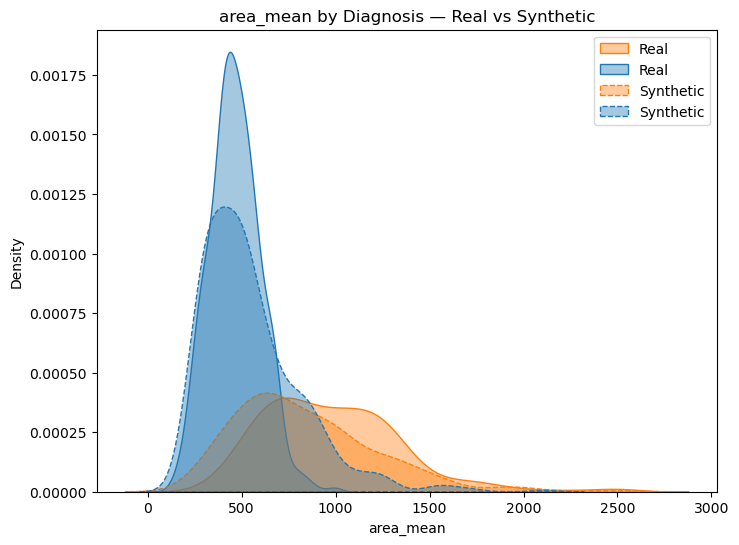

In [25]:
# Compare conditional distributions (numeric ↔ categorical)

import seaborn as sns

feature = "area_mean"

plt.figure(figsize=(8,6))
sns.kdeplot(data=real_df, x=feature, hue="diagnosis", fill=True, alpha=0.4, label="Real")
sns.kdeplot(data=synth_df, x=feature, hue="diagnosis", fill=True, alpha=0.4, linestyle="--", label="Synthetic")
plt.title(f"{feature} by Diagnosis — Real vs Synthetic")
plt.legend()
plt.show()

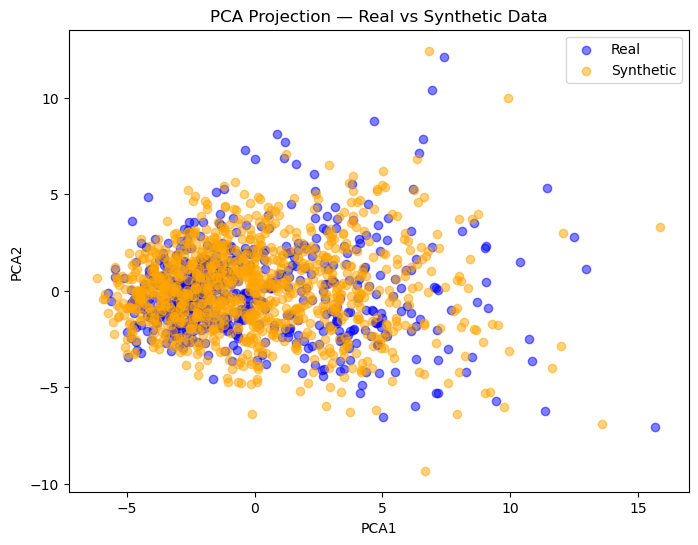

In [26]:
# PCA projection colored by dataset type

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

num_cols = [c for c in real_df.columns if c != "diagnosis"]
scaler = StandardScaler()
X_real = scaler.fit_transform(real_df[num_cols])
X_syn = scaler.transform(synth_df[num_cols])

pca = PCA(n_components=2)
X_all = np.vstack([X_real, X_syn])
pca_all = pca.fit_transform(X_all)

n_real = len(X_real)
labels = np.array(["Real"] * n_real + ["Synthetic"] * len(X_syn))

plt.figure(figsize=(8,6))
plt.scatter(pca_all[labels=="Real",0], pca_all[labels=="Real",1], color="blue", alpha=0.5, label="Real")
plt.scatter(pca_all[labels=="Synthetic",0], pca_all[labels=="Synthetic",1], color="orange", alpha=0.5, label="Synthetic")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Projection — Real vs Synthetic Data")
plt.legend()
plt.show()

# Multi-variate analysis

In [27]:
# MMD computation (global distribution distance)

from sklearn.metrics.pairwise import rbf_kernel
def mmd_rbf(X, Y, gamma=None):
    if gamma is None:
        Z = np.vstack([X, Y])
        dists = np.sqrt(((Z[:,None,:]-Z[None,:,:])**2).sum(-1))
        med = np.median(dists[dists>0])
        gamma = 1.0 / (2*(med**2))
    Kxx = rbf_kernel(X, X, gamma)
    Kyy = rbf_kernel(Y, Y, gamma)
    Kxy = rbf_kernel(X, Y, gamma)
    n, m = len(X), len(Y)
    return (Kxx.sum() - np.trace(Kxx))/(n*(n-1)) + (Kyy.sum() - np.trace(Kyy))/(m*(m-1)) - 2*Kxy.mean()

mmd_value = mmd_rbf(X_real, X_synth)
print("Global MMD (RBF):", mmd_value)

Global MMD (RBF): 0.8968401889350468


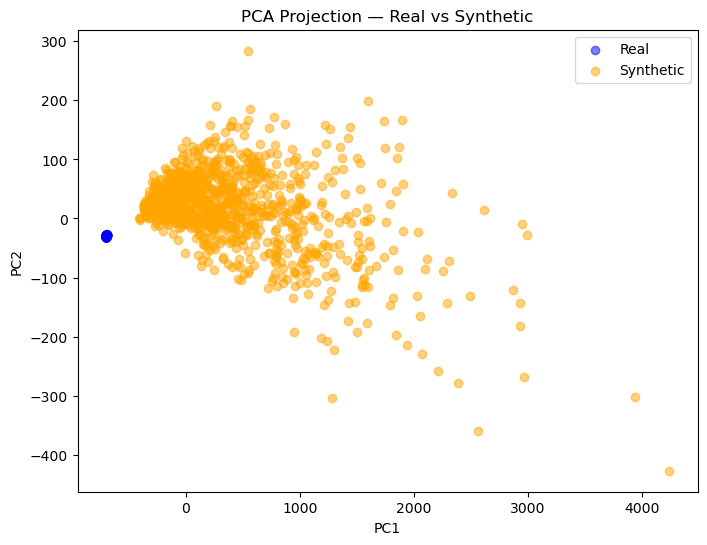

In [28]:
# PCA visualization

import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_all = np.vstack([X_real, X_synth])
labels = np.array(['Real'] * len(X_real) + ['Synthetic'] * len(X_synth))
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[labels=='Real',0], X_pca[labels=='Real',1], color='blue', alpha=0.5, label='Real')
plt.scatter(X_pca[labels=='Synthetic',0], X_pca[labels=='Synthetic',1], color='orange', alpha=0.5, label='Synthetic')
plt.title("PCA Projection — Real vs Synthetic")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.show()

In [29]:
# Classifier Two-Sample Test

y_real = np.ones(len(X_real))
y_synth = np.zeros(len(X_synth))
X = np.vstack([X_real, X_synth])
y = np.hstack([y_real, y_synth])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Two-Sample Classifier Accuracy:", acc)

Two-Sample Classifier Accuracy: 1.0
